# Alzheimer's disease identification from brain x-ray images

MLUB Night - Oct 26, 2023

## Data Processing

## 1. Install and import packages

Install necessary packages

In [2]:
%%capture
!pip install kaggle
!pip install sagemaker -U
!pip install smdebug

Import packages

In [3]:
import numpy as np
import pandas as pd

import os
import json
import random
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt

## 2. Download the dataset

We will download the [dataset from Kaggle](https://www.kaggle.com/datasets/tourist55/alzheimers-dataset-4-class-of-images/data) and the download instruction is given [here](https://www.kaggle.com/discussions/general/74235).

_Kaggle Account -> Settings -> API -> Create Kaggle token and download the .json file_

![image](Assets/Kaggle_token.png)

In [12]:
# create the .kaggle directory and an empty kaggle.json file
!mkdir -p /root/Intro-to-train-and-deploy-ML-model-AWS/.kaggle
!touch /root/Intro-to-train-and-deploy-ML-model-AWS/.kaggle/kaggle.json
!chmod 600 /root/Intro-to-train-and-deploy-ML-model-AWS/.kaggle/kaggle.json

In [7]:
# Fill in your user name and key from creating the kaggle account and API token file
from kaggle_config import kaggle_username, kaggle_key

# Save API token the kaggle.json file
with open("/root/.kaggle/kaggle.json", "w") as f:
    f.write(json.dumps({"username": kaggle_username, "key": kaggle_key}))

In [7]:
!kaggle datasets download -d tourist55/alzheimers-dataset-4-class-of-images

 79%|██████████████████████████████        | 27.0M/34.1M [00:00<00:00, 76.7MB/s]
100%|██████████████████████████████████████| 34.1M/34.1M [00:00<00:00, 64.0MB/s]


In [15]:
# If you already downloaded it you can use the -o command to overwrite the file
!unzip -o -qq alzheimers-dataset-4-class-of-images.zip

In [4]:
DATA_PATH='/root/Intro-to-train-and-deploy-ML-model-AWS/Alzheimer_s Dataset'

data_distribution = {}

for data_type in os.listdir(DATA_PATH):
    
    print(f"<<< {data_type} >>>")
    data_dir = os.path.join(DATA_PATH, data_type)
    
    data_distribution[data_type] = {}
    
    for sub_type in os.listdir(data_dir):
        sub_dir = os.path.join(data_dir, sub_type)
        type_cnt = len(os.listdir(sub_dir))
        
        data_distribution[data_type][sub_type] = type_cnt
        
        print(f"'{sub_type}': {type_cnt}")

<<< test >>>
'MildDemented': 180
'VeryMildDemented': 448
'NonDemented': 640
'ModerateDemented': 12
<<< valid >>>
'MildDemented': 135
'VeryMildDemented': 327
'NonDemented': 469
'ModerateDemented': 10
<<< train >>>
'MildDemented': 582
'VeryMildDemented': 1465
'NonDemented': 2091
'ModerateDemented': 42


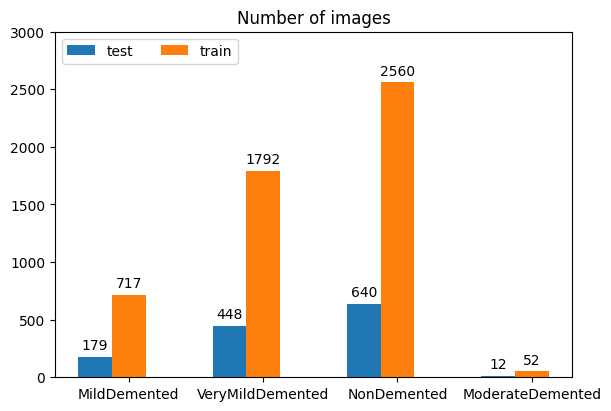

In [5]:
x = np.arange(4)
width = 0.25
multiplier = 0

fig, ax = plt.subplots(layout='constrained', figsize=(6,4))

for data_type, labels in data_distribution.items():
    offset = width * multiplier
    chart = ax.bar(x + offset, labels.values(), width, label=data_type)
    ax.bar_label(chart, padding=3)
    multiplier += 1

ax.set_title('Number of images')
ax.set_xticks(x + width, labels.keys())
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 3000)

plt.show()

## 3. Data split

Show sample images

In [ ]:
plt.figure(figsize=(10, 10))
fig, ax = plt.subplots(2,3)

for e, data_type in enumerate(['train', 'test']):
    for i in range(3):
        data_dir = os.path.join(DATA_PATH, data_type)
        sub_type = random.choice(os.listdir(data_dir))
        sub_dir = os.path.join(data_dir, sub_type)
        image_name = random.choice(os.listdir(sub_dir))
        img_dir = os.path.join(sub_dir, image_name)
        img = Image.open(img_dir)

        ax[e, i].imshow(img, cmap = 'gray')
        ax[e, i].set_title(f"{data_type}: {sub_type},\n size: {img.size}", size=8)
        ax[e, i].axis('off')
        
fig.suptitle("Sample dementia brain x-rays")
plt.show()
None

The dataset only contains train and test sets. Created validation set by randomly sampling `20% of the train data` and sampled 20% of each dementia severity as validation set.

In [23]:
!mkdir /root/Intro-to-train-and-deploy-ML-model-AWS/"Alzheimer_s Dataset"/valid

In [24]:
from_dir = os.path.join(DATA_PATH, 'train')
to_dir = os.path.join(DATA_PATH, 'valid')

for sub_type in os.listdir(from_dir):
    from_sub_dir = os.path.join(from_dir, sub_type)
    to_sub_dir = os.path.join(to_dir, sub_type)

    os.mkdir(to_sub_dir)
    print("Created: ", to_sub_dir)
    
    valid_samples = np.random.choice(os.listdir(from_sub_dir), int(0.2*len(os.listdir(from_sub_dir))))
    
    for file in valid_samples:
        rm_dir = os.path.join(from_sub_dir, file)
        cp_dir = os.path.join(to_sub_dir, file)
        
        try:
            os.rename(rm_dir, cp_dir)
        except:
            pass
        
    print(f"<<< {sub_type} moved to valid : {len(os.listdir(to_sub_dir))} >>>")

Created:  /root/Intro-to-train-and-deploy-ML-model-AWS/Alzheimer_s Dataset/valid/MildDemented
<<< MildDemented moved to valid : 135 >>>
Created:  /root/Intro-to-train-and-deploy-ML-model-AWS/Alzheimer_s Dataset/valid/VeryMildDemented
<<< VeryMildDemented moved to valid : 327 >>>
Created:  /root/Intro-to-train-and-deploy-ML-model-AWS/Alzheimer_s Dataset/valid/NonDemented
<<< NonDemented moved to valid : 469 >>>
Created:  /root/Intro-to-train-and-deploy-ML-model-AWS/Alzheimer_s Dataset/valid/ModerateDemented
<<< ModerateDemented moved to valid : 10 >>>


## 4. Upload the data to S3

1. Create the bucket in S3
2. Get the bucket name
3. Push the data to S3

In [5]:
BUCKET = "mlub-dementia-demo"

In [6]:
!aws s3 --quiet sync '/root/Intro-to-train-and-deploy-ML-model-AWS/Alzheimer_s Dataset' s3://{BUCKET}/"Alzheimer_s Dataset"

In [5]:
# !aws s3 --quiet sync '/root/Intro-to-train-and-deploy-ML-model-AWS/Alzheimer_s Dataset/valid/ModerateDemented' s3://{BUCKET}/"Test Dataset" 

The end of the notebook